# Next: isolate visual stim with no turn response
# isolate spontaneous turns
# make time traces of each roi

In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_134/func_0/'

In [3]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374


In [4]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [5]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300

behavior_traces = {}
mean_trace = {}
sem_trace = {}
for angle in [0,180]:
    behavior_traces[angle],mean_trace[angle],sem_trace[angle] = brainsss.extract_traces(fictrac,
                                                                                        starts_angle[angle],
                                                                                        pre_window,
                                                                                        post_window)

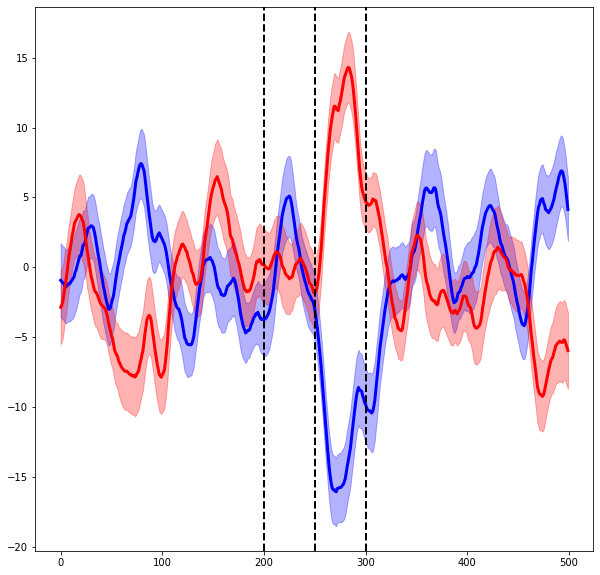

In [6]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    plt.plot(mean_trace[angle],color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [10]:
#####################################
### Extract Visually Evoked Turns ###
#####################################
#fly 134
#r_thresh=.3, 
#av_thresh=50,


ve_turns = {}
ve_turn_times = {}
for angle,direction in zip([0,180],['neg','pos']):
    ve_turns[angle], ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
                                                                               mean_trace[angle],
                                                                      start=250, 
                                                                      stop=300, 
                                                                      r_thresh=.3, 
                                                                      av_thresh=50, 
                                                                      stim_times=starts_angle_ms[angle],
                                                                      expected_direction=direction)

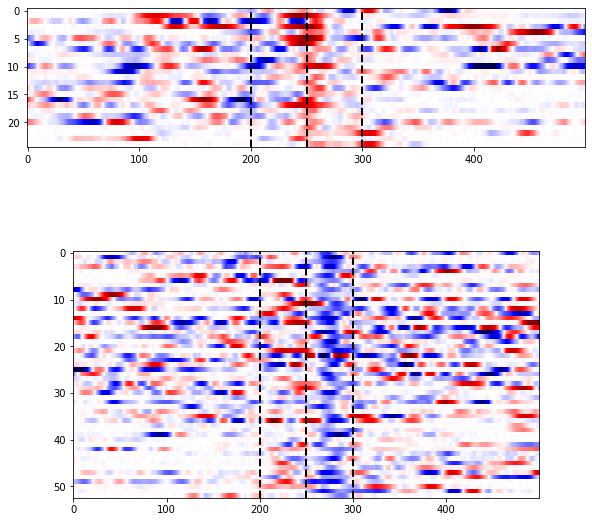

In [11]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

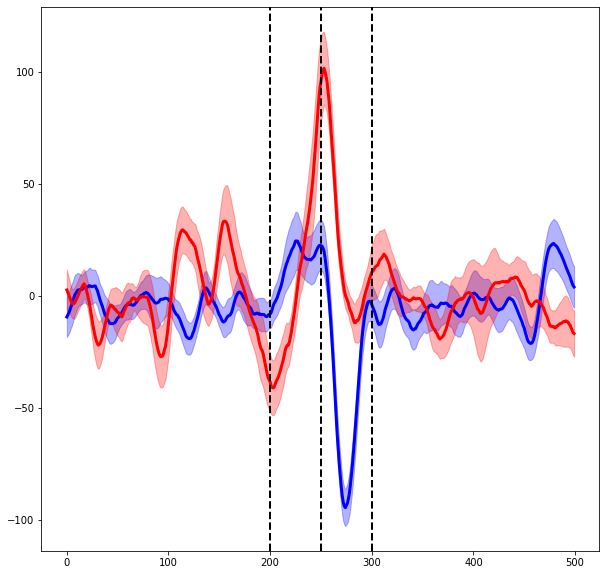

In [12]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [13]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [14]:
ve_no_turns = {}
ve_no_turn_times = {}
for angle in [0,180]:
    ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
                                  start=250,
                                  stop=300,
                                  num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
                                  stim_times=starts_angle_ms[angle])

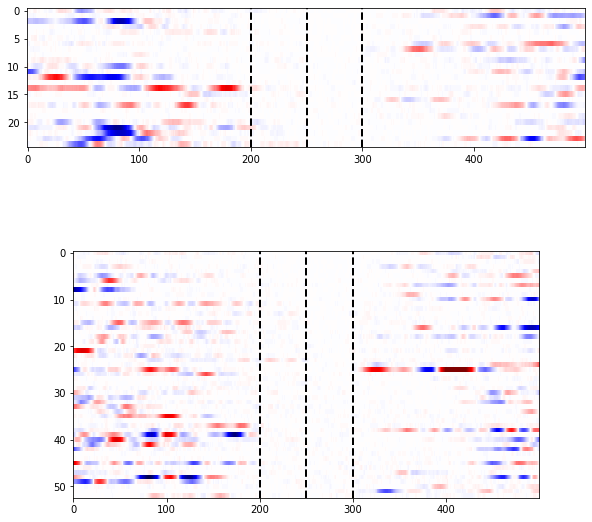

In [15]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_no_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_no_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

(-50, 50)

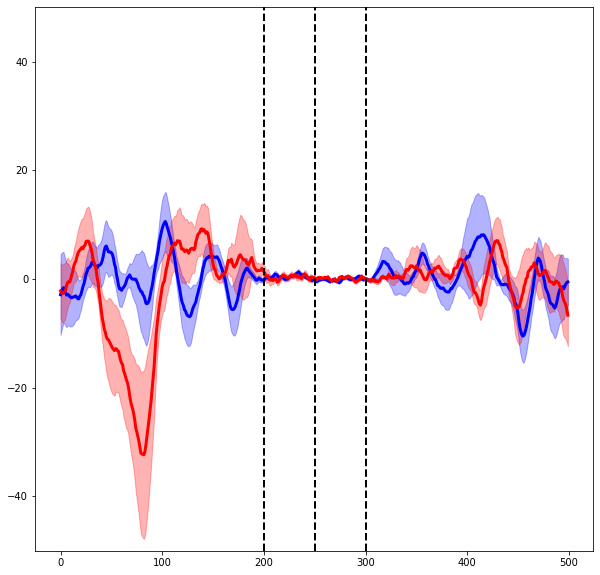

In [16]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.ylim(-50,50)

# extract grey baseline

In [17]:
##########################
### GET WALKING VECTOR ###
##########################

y_std = fictrac['Y']/np.std(fictrac['Y'])
z_std = fictrac['Z']/np.std(fictrac['Z'])
movement = (y_std**2 + z_std**2)**0.5
movement = scipy.ndimage.filters.gaussian_filter(movement,sigma=10)
walking = np.zeros(len(movement))
walking[np.where(movement>0.2)] = 1

In [18]:
######################
### GET GREY TIMES ###
######################

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'ConstantBackground':
        grey_starts.append(stimulus_start_times[i])
        grey_stops.append(stimulus_start_times[i]+60)
grey_starts = [i*1000 for i in grey_starts] #s to ms
grey_stops = [i*1000 for i in grey_stops] #s to ms

grey_periods = np.zeros(len(walking))
for i in range(len(grey_starts)):
    grey_periods[np.where((grey_starts[i] < fictrac_timestamps) & (fictrac_timestamps < grey_stops[i]))[0]] = 1

In [19]:
grey_starts

[1309.1999999999998, 444198.8, 887138.4, 1329944.7, 1772859.3]

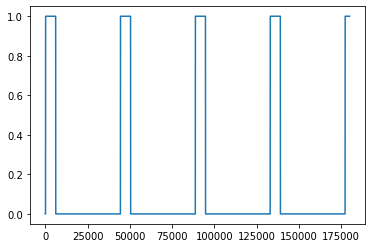

In [20]:
plt.plot(grey_periods)

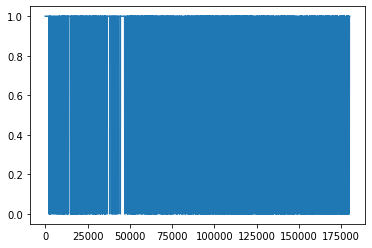

In [21]:
plt.plot(walking)

In [22]:
np.sum(walking==0), np.sum(walking==1)

(57311, 122689)

In [26]:
slice_avgs = []
for z in range(49):
    idx = np.ndarray.astype(timestamps[:,z]/10,'int')[:-1] # remove last idx because it could go over 1800s
    grey_and_stopped = np.logical_and(walking[idx] == 0, grey_periods[idx]==1)
    grey_and_walking = np.logical_and(walking[idx] == 1, grey_periods[idx]==1)
    grey_and_stopped = np.append(grey_and_stopped, False)
    slice_avgs.append(np.mean(all_signals[z,:,grey_and_stopped],axis=0))
baseline_brain = np.asarray(slice_avgs)
baseline_brain.shape

(49, 2000)

In [122]:
# baseline_brain = brainsss.STA_supervoxel_to_full_res(slice_avgs[:,np.newaxis,:], cluster_labels)
# baseline_brain = baseline_brain[:,0,:,:]
# baseline_brain.shape

(49, 256, 128)

In [27]:
out = STA_brain - baseline_brain[:,np.newaxis,:]


NameError: name 'STA_brain' is not defined

In [28]:
STA_brain.shape

NameError: name 'STA_brain' is not defined

# load neural

In [24]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [25]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [33]:
fixed = brainsss.load_fda_meanbrain()

In [34]:
atlas = brainsss.load_roi_atlas()

In [35]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [30]:
bin_start = -1100; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

# roi avg over time

In [31]:
#ooo we need to warp atlas into this brain space
#do that way later

In [36]:
all_warps = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    STA_brain -= baseline_brain[:,np.newaxis,:]
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    all_warps[condition] = np.asarray(warps)
    print(F'Warps {time.time()-t0}')

ve_no_0
STA 0.6055343151092529
Warps 11.00858759880066
ve_no_180
STA 0.31586360931396484
Warps 10.652796745300293
ve_0
STA 0.5978245735168457
Warps 10.785325527191162
ve_180
STA 0.31958627700805664
Warps 10.77709674835205


(array([2.00000000e+00, 4.00000000e+00, 1.80000000e+01, 7.78000000e+02,
        4.04947000e+05, 1.22295695e+08, 2.10238700e+06, 3.02445000e+05,
        4.52960000e+04, 2.54800000e+03]),
 array([-2.0725589 , -1.6930021 , -1.3134453 , -0.9338886 , -0.55433184,
        -0.17477506,  0.2047817 ,  0.5843385 ,  0.9638952 ,  1.343452  ,
         1.7230088 ], dtype=float32),
 <a list of 10 Patch objects>)

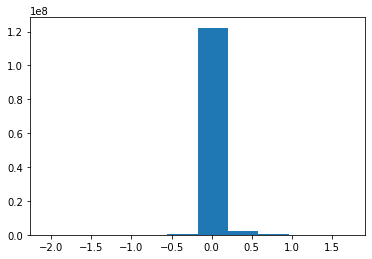

In [41]:
plt.hist(all_warps['ve_no_0'].flatten())

In [172]:
all_warps['ve_0'].shape

(30, 314, 146, 91)

In [256]:
STA_in_atlas_space = {}
for condition in ['ve_0','ve_180']: #'ve_no_0','ve_no_180',
    t0 = time.time()
    print(condition)
    roi_time_avgs = []
    for roi in roi_masks:
        mask = roi_masks[roi]
        masked_data = np.clip(all_warps[condition],0,None)*mask[np.newaxis,:,:,:]
        roi_time_avg = np.max(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    STA_in_atlas_space[condition] = np.asarray(roi_time_avgs)
    print(time.time()-t0)

ve_0
55.570502519607544
ve_180
55.69777154922485


In [245]:
np.where(np.asarray(all_rois)==83)[0][0]
#43,55

55

In [269]:
explosion_rois

{'AOTU_L': {'rois': {79: 'AOTU_L'}, 'x_shift': 80, 'y_shift': 110},
 'AOTU_R': {'rois': {34: 'AOTU_R'}, 'x_shift': -80, 'y_shift': 110},
 'EB': {'rois': {23: 'EB'}, 'x_shift': 0, 'y_shift': 35},
 'FB_group': {'rois': {4: 'NO',
   5: 'BU_R',
   8: 'LAL_R',
   26: 'FB',
   31: 'PVLP_R',
   54: 'BU_L',
   56: 'LAL_L',
   76: 'PVLP_L'},
  'x_shift': 0,
  'y_shift': 0},
 'LO_L': {'rois': {53: 'LO_L'}, 'x_shift': 140, 'y_shift': 215},
 'LO_R': {'rois': {3: 'LO_R'}, 'x_shift': -140, 'y_shift': 215},
 'LP_L': {'rois': {69: 'LP_L'}, 'x_shift': 140, 'y_shift': 145},
 'LP_R': {'rois': {22: 'LP_R'}, 'x_shift': -140, 'y_shift': 145},
 'MED_L': {'rois': {71: 'MED_L'}, 'x_shift': 200, 'y_shift': 175},
 'MED_R': {'rois': {25: 'MED_R'}, 'x_shift': -200, 'y_shift': 175},
 'PB': {'rois': {6: 'PB'}, 'x_shift': 0, 'y_shift': -45},
 'anterior_group': {'rois': {9: 'SAD',
   10: 'CAN_R',
   17: 'MB_PED_R',
   18: 'MB_VL_R',
   19: 'MB_ML_R',
   20: 'FLA_R',
   24: 'AL_R',
   30: 'AVLP_R',
   32: 'IVLP_R',
   

In [233]:
list(explosion_rois[roi_group]['rois'].keys())

[26, 4, 5, 54, 8, 56, 31, 76]

In [201]:
roi_time_avgs_array = []
for roi in roi_masks:
    roi_time_avgs_array.append(roi_time_avgs[roi])
roi_time_avgs_array = np.asarray(roi_time_avgs_array)

In [217]:
roi_time_avgs_array.shape

(71, 30)

In [219]:
for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    print(mean_ve_trace.shape)

(500,)
(500,)


In [ ]:
#so, there is a laser scan frequency signal in the neural data
#

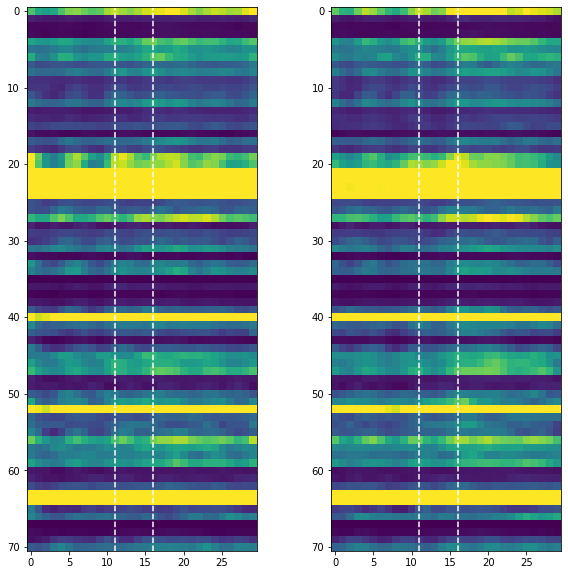

In [225]:
plt.figure(figsize=(10,10))
for i,condition in enumerate(['ve_0','ve_180']):
    plt.subplot(1,2,i+1)
    plt.imshow(STA_in_atlas_space[condition],vmin=0,vmax=.0004)
    for line in [11,16]:
        plt.axvline(line,color='white',linestyle='--')

In [ ]:
#see if flies with longer grey have this.
#check in tomato
gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

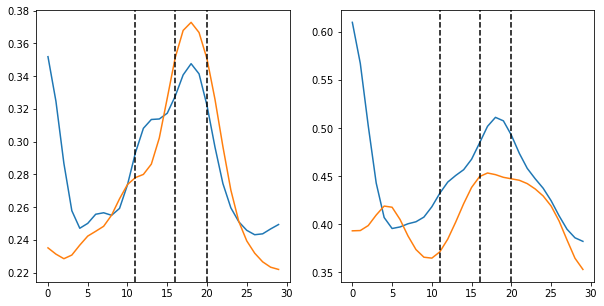

In [268]:
sigma = 2
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_0'][43],sigma=sigma))
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_180'][43],sigma=sigma))
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')
    
plt.subplot(122)
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_0'][55],sigma=sigma))
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_180'][55],sigma=sigma))
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')

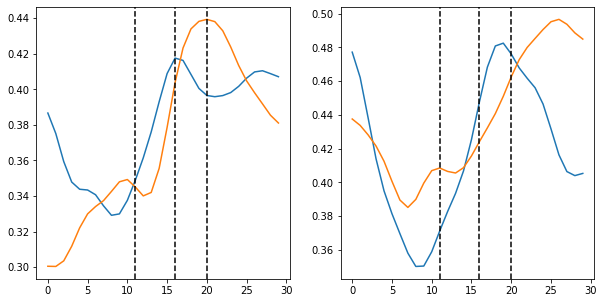

In [270]:
sigma = 2
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_0'][8],sigma=sigma))
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_180'][8],sigma=sigma))
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')
    
plt.subplot(122)
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_0'][56],sigma=sigma))
plt.plot(gaussian_filter1d(STA_in_atlas_space['ve_180'][56],sigma=sigma))
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')

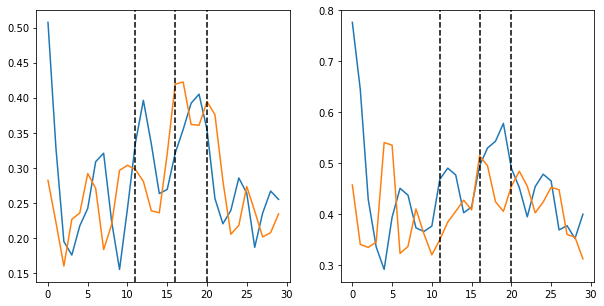

In [261]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(STA_in_atlas_space['ve_0'][43])
plt.plot(STA_in_atlas_space['ve_180'][43])
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')
    
plt.subplot(122)
plt.plot(STA_in_atlas_space['ve_0'][55])
plt.plot(STA_in_atlas_space['ve_180'][55])
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')

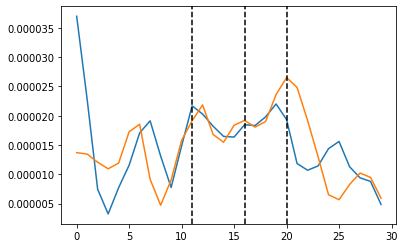

In [254]:
plt.plot(STA_in_atlas_space['ve_0'][43])
plt.plot(STA_in_atlas_space['ve_180'][43])
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')

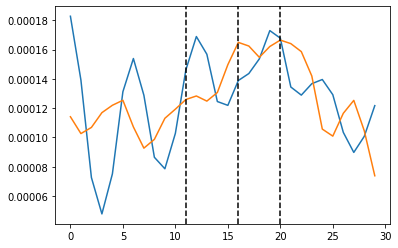

In [255]:
plt.plot(STA_in_atlas_space['ve_0'][55])
plt.plot(STA_in_atlas_space['ve_180'][55])
for line in [11,16,20]:
    plt.axvline(line,color='k',linestyle='--')

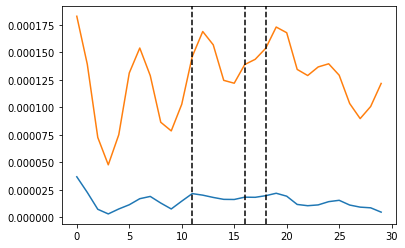

In [250]:
plt.plot(STA_in_atlas_space['ve_0'][43])
plt.plot(STA_in_atlas_space['ve_0'][55])
for line in [11,16,18]:
    plt.axvline(line,color='k',linestyle='--')

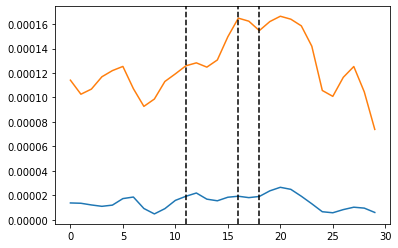

In [251]:
plt.plot(STA_in_atlas_space['ve_180'][43])
plt.plot(STA_in_atlas_space['ve_180'][55])
for line in [11,16,18]:
    plt.axvline(line,color='k',linestyle='--')

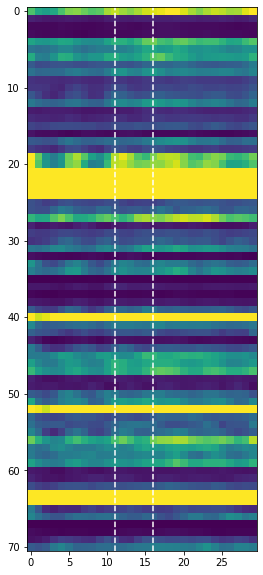

In [215]:
plt.figure(figsize=(10,10))
for i,condition in enumerate(['ve_0','ve_180']):
    plt.subplot(1,2,i+1)
    plt.imshow(roi_time_avgs_array,vmin=0,vmax=.0004)
    for line in [11,16]:
        plt.axvline(line,color='white',linestyle='--')

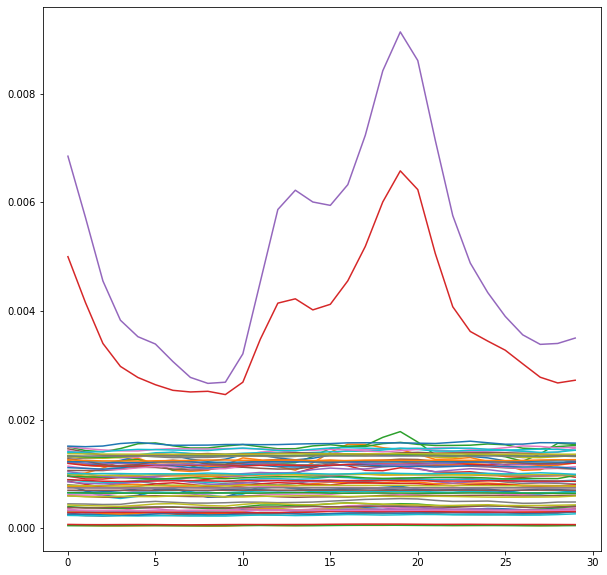

In [220]:
#
plt.figure(figsize=(10,10))
for i, roi in enumerate(roi_masks):
    plt.plot(roi_time_avgs[roi]+.00002*i)
#plt.ylim(0,.002)
#plt.

In [148]:
atlas.shape

(314, 146, 91)

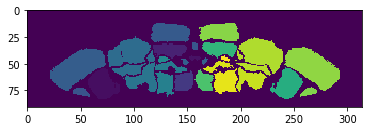

In [162]:
plt.imshow(atlas[:,66,:].T)

# STA wrapped

In [138]:
all_explosions = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    STA_brain -= baseline_brain[:,np.newaxis,:]
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3))
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

ve_no_0
STA 1.3608875274658203
Warps 21.05754065513611
Explosion 57.85936737060547
ve_no_180
STA 1.4488632678985596
Warps 20.66348171234131
Explosion 57.94966506958008
ve_0
STA 1.4020285606384277
Warps 20.704373598098755
Explosion 58.16023230552673
ve_180
STA 1.494779348373413
Warps 24.31737518310547
Explosion 57.65077447891235


In [130]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(2,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

In [139]:
for tp in range(len(neural_bins)-1):
    print(tp)
    fig = plt.figure(figsize=(14.8,10))

    plot_panel('ve_no_0', tp, 1)
    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
    plot_panel('ve_no_180', tp, 2)
    plot_panel('ve_0', tp, 3)
    plot_panel('ve_180', tp, 4)
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.suptitle('20220502_fly_134',y=.9)


#     cax = fig.add_axes([0.47, 0.66, 0.01, 0.2])
#     cmap = matplotlib.cm.hot
#     norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
#     cb = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,
#                                     norm=norm,
#                                     orientation='vertical')

#     cb.ax.yaxis.set_tick_params(color='k')
#     plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='k',fontsize=12);
#     cb.outline.set_edgecolor('white')
    
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220505b_movie'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [3]:
'{0:02d}.png'.format(1)

'01.png'

# STA analysis

In [123]:
angle = 180

STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = starts_angle_ms[angle],
                                   neural_bins = neural_bins)

In [17]:
reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)

In [18]:
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

In [20]:
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')

In [23]:
len(neural_bins)

9

In [24]:
explosions = []
for tp in range(len(neural_bins)-1):
    input_canvas = np.zeros((500,500,3))
    data_to_plot = warps[tp][:,:,::-1]# - warps[0][:,:,::-1]
    vmax = 0.5

    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='hot')
    explosions.append(explosion_map)

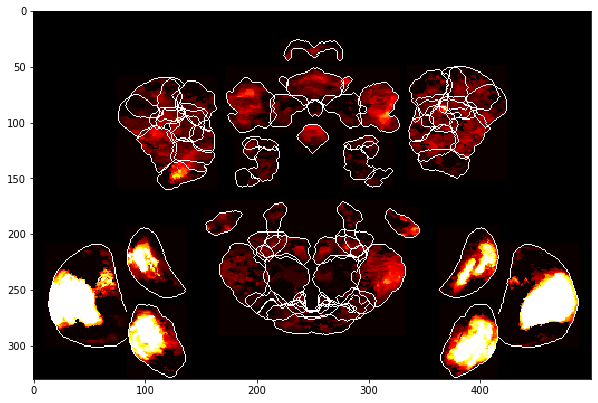

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(explosions[7][170:,:])

In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid

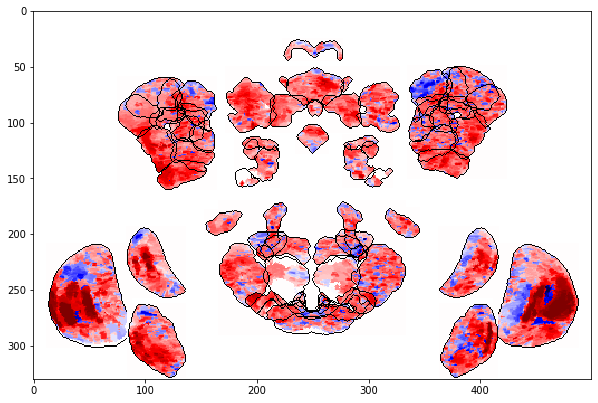

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(all_explosions['ve_0'][10][170:,:])

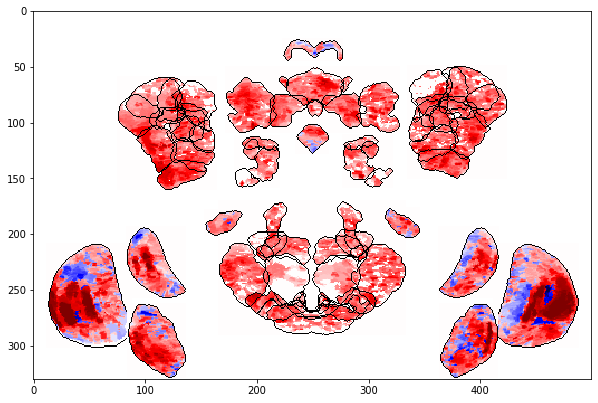

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(all_explosions['ve_0'][10][170:,:])

In [ ]:
### get grey baseline

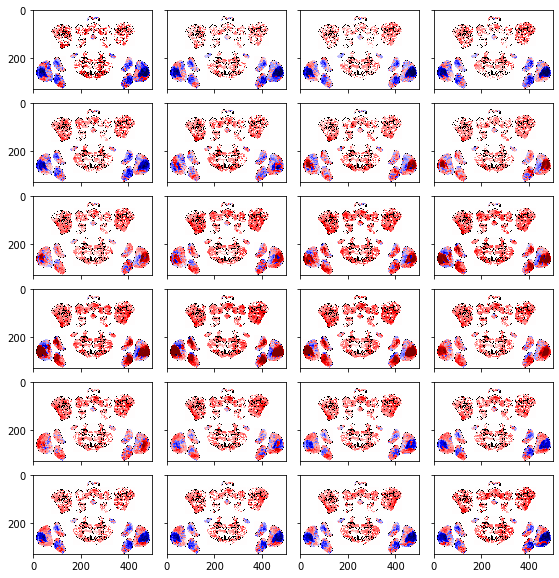

In [25]:
fig = plt.figure(figsize=(10,10))

grid = ImageGrid(fig, 111, nrows_ncols=(6, 4), axes_pad=.2)
for i in range(24):
    grid[i].imshow(all_explosions['ve_0'][i][170:,:])